In [1]:
from entities import *
from constants import TEAMS_DATA, STAT_EFFECTS, POSSESSIONS_STD_DEV
from simulations import *

import pickle
import numpy as np
import pandas as pd

In [2]:
with open(TEAMS_DATA, 'rb') as f:
    teams = pickle.load(f)

with open(STAT_EFFECTS, 'rb') as f:
    stats = pickle.load(f)

In [3]:
test = simulate_n_games(teams['Kansas'], teams['Connecticut'], 500)

Simulating Game: Kansas vs. Connecticut


100%|██████████| 500/500 [00:12<00:00, 41.50it/s]


Preparing simulation analysis.
Kansas vs. Connecticut Complete!
Connecticut's balanced scoring, superior ball control, and stronger rebounding outpace Kansas, with fewer turnovers and efficient two-point and three-point offense driving the Huskies' long-run advantage.


In [4]:
test['Record']

'Kansas: 238 - 262 :Connecticut'

In [5]:
test['Contributions']

,Team,2P,2PA,3P,3PA,BLK,STL,TOV,ORB,DRB,PF,Games Played
Bryson Tiller,Kansas,1431,2588,384,1318,838,47,886,551,2756,1270,357
Darryn Peterson,Kansas,988,1482,741,1727,163,408,327,0,817,245,152
Flory Bidunga,Kansas,3186,5292,0,53,1276,265,930,1383,3244,1223,396
Kohl Rosario,Kansas,755,755,621,2346,142,285,550,550,693,1244,303
Tre White,Kansas,1435,2429,721,1610,218,327,1118,1228,2701,1391,406
Alex Karaban,Connecticut,1486,2612,1023,2353,602,459,344,918,1837,1176,426
Eric Reibe,Connecticut,2681,3920,205,547,888,205,547,957,2211,1436,339
Jayden Ross,Connecticut,780,1560,570,1354,367,504,275,573,1216,1721,343
Malachi Smith,Connecticut,744,2378,661,1250,73,514,735,367,1029,809,364
Solomon Ball,Connecticut,1712,2834,1176,4057,166,472,833,416,1528,1111,413


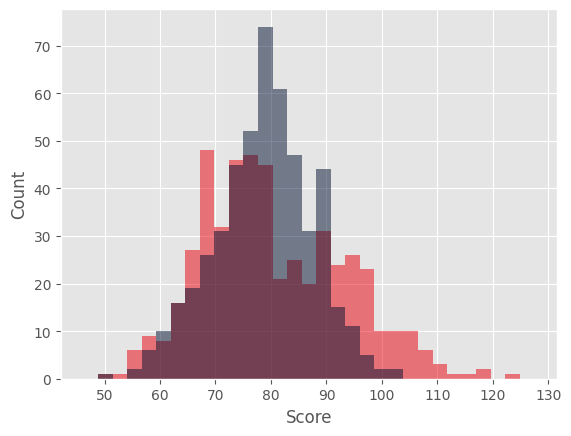

In [6]:
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.style.use('ggplot')

kansas = test['Scores']['Kansas']
uconn = test['Scores']['Connecticut']

min_score = min(kansas + uconn)
max_score = max(kansas + uconn)
bins = np.linspace(min_score-5, max_score+5, 32)

plt.hist(kansas, bins=bins, color='#e8000d', alpha=0.5)
plt.hist(uconn, bins=bins, color='#000E2F', alpha=0.5)
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [7]:
test['Analysis']

"Connecticut outpaced Kansas, aided by balanced scoring, stronger rebounding, and fewer turnovers. Kansas volume surged, but efficiency and defense lagged, shifting the simulation result in Connecticut's favor."

In [22]:
print(
f"""
{test['Team 1'].name} has won {test['Win Count 1']} games ({round(test['Team 1 Win Pct'] * 100, 2)}%)
{test['Team 2'].name} has won {test['Win Count 2']} games ({round(test['Team 2 Win Pct'] * 100, 2)}%)

Overall winner: {test['Winner']}
""")


Kansas has won 238 games (47.6%)
Connecticut has won 262 games (52.4%)

Overall winner: Connecticut

